# Statistics in Aviation History and Safety

Mohammed Farhan \
April 11, 2023

In [1]:
# importing libraries and dataset
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib.patches import Rectangle
from ipywidgets import interact, Layout, HBox
df = pd.read_csv('flights.csv')

## First Visualization - Lineplot

In [2]:
df.insert(2, 'year', df['date'].str[0:4].values, True)
df2 = df[['region', 'year']].groupby(['year', 'region']).agg({'region': ['count']}).xs('region', axis=1, drop_level=True).reset_index()
region_order = np.sort(np.append(df2.region.unique(),'ALL'))

In [3]:
def wrapper1(region):
    plt.style.use("bmh")
    fig, ax = plt.subplots(figsize=(15,8))
    df3 = df2[df2.region != region]
    df_single = df2[df2.region == region]
    colors = ['grey']*6
    color_single = ["blueviolet"]
    if region == 'ALL': 
        df3 = df2
        plot1 = sns.lineplot(x='year', y='count', data=df3, hue='region', palette='nipy_spectral', hue_order=region_order[1:],\
                             style='region', errorbar=('ci',5), markers=True, estimator=sum, linewidth=4, markersize=10.0)
    else:
        plot1 = sns.lineplot(x='year', y='count', data=df3, hue='region', palette=colors, style='region', errorbar=('ci',5),\
                             hue_order=region_order[region_order!=region][1:], markers=True, estimator=sum, linewidth=3, alpha=0.2)
        sns.lineplot(x='year', y='count', data=df_single, hue='region', palette=sns.color_palette(color_single, 1),\
                     style='region', errorbar=('ci',5), markers=['h'], estimator=sum, linewidth=1, markersize=11.5,\
                     markeredgecolor='lime')
        for n in range(1, 10):
            sns.lineplot(x='year', y='count', data=df_single, hue='region', palette=sns.color_palette(color_single, 1),\
                         style='region', errorbar=('ci',5), markers=['h'], estimator=sum, linewidth=1.05*n, markersize=11.5,\
                         markeredgecolor='lime', legend=False, alpha=0.05)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = list(enumerate(labels))
    labels_r = sorted(labels, key=lambda x:x[1])
    order, vals = zip(*labels_r)
    handles_r = [handles[pos] for pos in order]
    plt.legend(handles_r, vals)
    sns.move_legend(plot1, "upper right", framealpha=0, title=None)
    sns.despine()
    ax.grid(axis='y', color='silver')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    fig.patch.set_facecolor('white')
    plt.setp(ax.get_legend().get_texts(), fontsize='12', color='black')
    plot1.set_xticks([0.01,0,0,0,4,0,0,0,8,0,0,0,12,0,0,0,16,0,0,0,20,0,0,0,24])
    plot1.set_xticklabels(['1998','','','','2002','','','','2006','','','','2010','','','','2014','','','','2018','','','','2022'])
    plot1.set_xlabel('Year', color='black', fontsize=14, labelpad=12)
    plot1.set_ylabel('Accident Count', color='black', fontsize=14, labelpad=12)
    plot1.set_title('Accident History by Region (1998 to 2022)', color='black', fontfamily='monospace', fontsize=16, pad=10)

In [4]:
call=interact(wrapper1, region=widgets.ToggleButtons(options=region_order, button_style='',\
                                                  style={"button_width": "110px"}))

interactive(children=(ToggleButtons(description='region', options=('ALL', 'ATLANTIC', 'CENTRAL', 'FOREIGN', 'O…

## Second Visualization - Barplot

In [5]:
df4 = df[df['operation_type'].isin(df['operation_type'].value_counts().reset_index()['index'].values[0:8]) &
        df['incident_type'].isin(df['incident_type'].value_counts().reset_index()['index'].values[0:9])][ \
        ['incident_type', 'operation_type']].groupby(['operation_type', 'incident_type']) \
                                            .agg({'incident_type': ['count']}).xs('incident_type', axis=1, drop_level=True) \
                                            .reset_index()

ops = df4.sort_values(by='count', ascending=False).operation_type.unique()
mapping = {op: i for i, op in enumerate(ops)}
key = df4['operation_type'].map(mapping)
df4 = df4.iloc[key.argsort()]

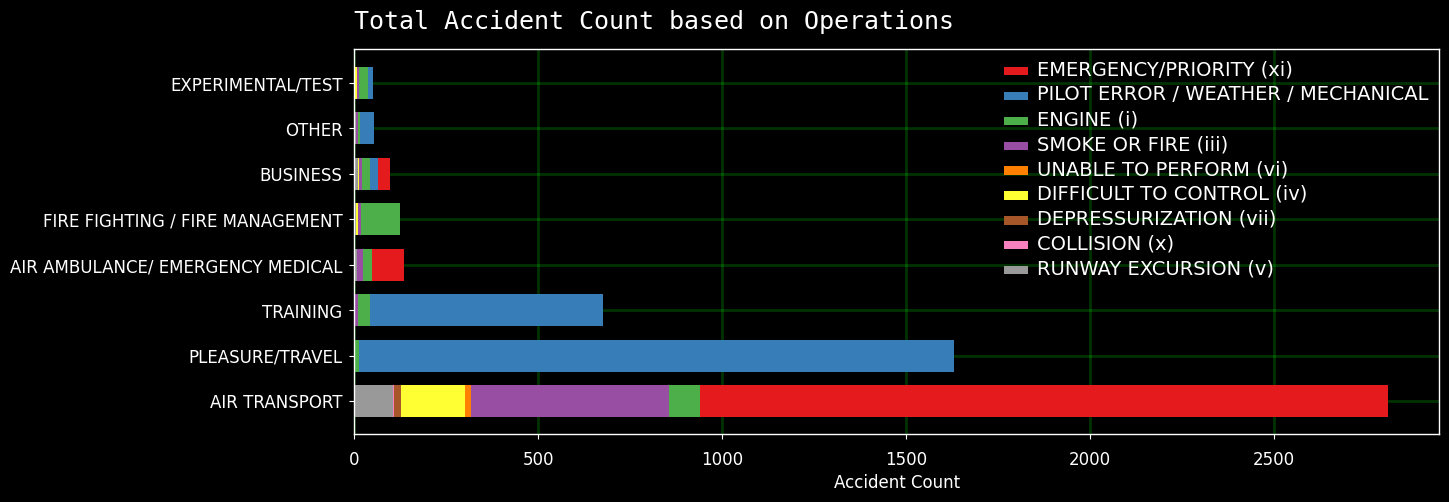

In [37]:
def wrapper2():
    plt.style.use("dark_background")
    fig, ax = plt.subplots(figsize=(14,5))
    ctr = 0
    cmap = plt.get_cmap("turbo")
    # colors = ['black','aqua','darkorange','red','blue','mediumpurple','brown','dimgrey','yellow']
    colorbrewer_cols = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628','#f781bf','#999999']
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
    for incident in df4.sort_values(by='count', ascending=False).incident_type.unique():
        operation = ax.barh(df4[df4.incident_type == incident]['operation_type'], \
                            df4[df4.incident_type == incident]['count'], \
                            0.7, label=incident, color=colorbrewer_cols[ctr])     #cmap(ctr/10)
        ctr += 1
    ax.set_xlabel('Accident Count')
    ax.set_axisbelow(True)
    ax.tick_params(axis='x', labelsize=12, pad=8)
    ax.tick_params(axis='y', labelsize=12, pad=5)
    ax.set_title('Total Accident Count based on Operations', fontfamily='monospace', fontsize=18, pad=15, loc='left')
    ax.legend(loc='upper right', framealpha=0.0, prop={'size': 8.5})
    plt.setp(ax.get_legend().get_texts(), fontsize='14')
    plt.grid(alpha=0.2, color='lime', linewidth=2, linestyle='-')
wrapper2()

## Third Visualization - Heatmap

In [7]:
def table_maker(df, x, y, lim):
    k=df[df[y].isin(df[y].value_counts().reset_index()['index'].values[0:lim]) &\
            df[x].isin(df[x].value_counts().reset_index()['index'].values[0:14])]\
                    [[x, y]].groupby([x, y])\
                                    .agg({y: ['count']})\
                                    .xs(y, axis=1, drop_level=True)\
                                    .reset_index().sort_values(by=x, ascending=True)
    arr=k[[y, 'count']].groupby(y)\
                            .sum().sort_values(by='count', ascending=False)\
                            .reset_index()[y]\
                            .values
    k2 = k.pivot(index=y, columns=x, values='count').fillna(0)
    k3 = k2.reindex(arr)
    return k3

In [30]:
def wrapper3(region):
    df_plane = df[df['aircraft_type']=='AEROPLANE']
    if region == 'AIRPORT':
        table = table_maker(df_plane, 'aircraft_make', 'airport_name', 20)
    if region == 'MODEL':
        table = table_maker(df_plane, 'aircraft_make', 'aircraft_model', 20)
    if region == 'INCIDENT':
        table = table_maker(df_plane, 'aircraft_make', 'incident_type', 19)
    if region == 'ORGANIZATION':
        table = table_maker(df_plane, 'aircraft_make', 'organization', 20)
    plt.style.use("ggplot")
    fig, ax = plt.subplots(figsize=(14,9))
    sns.heatmap(data=table, cmap='turbo', annot=True, fmt=".0f", picker=True)
    plt.xticks(rotation=35)
    if region == 'AIRPORT': ax.set_ylabel('Airport', fontsize=13)
    elif region == 'MODEL': ax.set_ylabel('Aeroplane Model', fontsize=13)
    elif region == 'INCIDENT': ax.set_ylabel('Incident Type', fontsize=13)
    else: ax.set_ylabel('Organization')
    ax.set_xlabel('Aircraft Make', fontsize=13)
    ax.set_title('Total Accident Count based on Aircraft Make', color='black', pad=10, fontfamily='monospace')

In [31]:
call=interact(wrapper3, region=widgets.ToggleButtons(options=['AIRPORT', 'ORGANIZATION', 'MODEL', 'INCIDENT'], button_style='info',\
                                                     disabled=False, style={"button_width": "230px"}))

interactive(children=(ToggleButtons(button_style='info', description='region', options=('AIRPORT', 'ORGANIZATI…

## Fourth Visualization - Chloropleth

In [10]:
newdf = geopandas.read_file('lpr_000b21a_e.shp')

In [11]:
x = 'airport_province'
y = 'aircraft_type'
k=df[df[y].isin(df[y].value_counts().reset_index()['index'].values[0:13])]\
                    [[x, y]].groupby([x, y])\
                                    .agg({y: ['count']})\
                                    .xs(y, axis=1, drop_level=True)\
                                    .reset_index().sort_values(by=x, ascending=True)

k_temp = k[[x, 'count']].groupby(x)\
                            .sum().sort_values(by='count', ascending=False)\
                            .reset_index()

In [12]:
newdf['PRENAME'] = newdf['PRENAME'].str.upper()
k_temp[x] = k_temp[x].str.upper()
newdf = newdf.to_crs("EPSG:4326")
tempdf = newdf.merge(k_temp, how='inner', left_on='PRENAME', right_on=x)
tempdf = tempdf.drop(x, axis=1)
tempdf['count'] = tempdf['count']/np.sum(tempdf['count'].values)

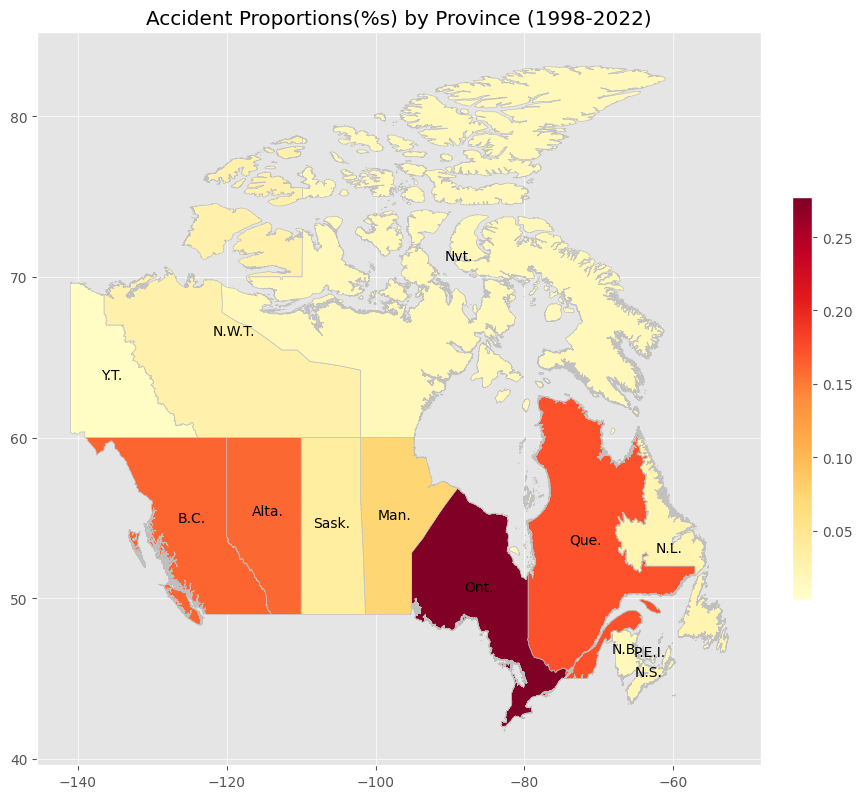

In [13]:
plt.style.use("ggplot")
ax = tempdf.plot(column='count', cmap='YlOrRd',\
                 legend=True, figsize=(10,10), legend_kwds={"fraction":0.026, "pad":0.04}, \
                 edgecolor='silver', linewidth=0.5)
tempdf.apply(lambda x: ax.annotate(text=x['PREABBR'], xy=x.geometry.centroid.coords[0], ha='center',\
                                  color='black'), axis=1)
ax.set_title('Accident Proportions(%s) by Province (1998-2022)', color='black', fontfamily='monospace')
ax.set_axisbelow(True)

## Attribution

- Stack Overflow, https://stackoverflow.com/
- Matplotlib Docs, https://matplotlib.org/stable/api/index
- Pandas Docs, https://pandas.pydata.org/docs/reference/
- Seaborn Docs, https://seaborn.pydata.org/api.html
- ipywidgets Docs, https://ipywidgets.readthedocs.io/en/stable/
- Geopandas Docs, https://geopandas.org/en/stable/docs/reference.html